In [ ]:
import argparse
import joblib
import torch
import torch.nn as nn
from torch import Tensor
from typing import *
import torch.nn.functional as F
from abc import abstractmethod
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.utils import shuffle
import random
from pandas.plotting import parallel_coordinates
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
# # %config InlineBackend.figure_format = 'svg'   
from xgboost import XGBRegressor                              

In [2]:
# CUDA_VISIBLE_DEVICES=4
print(torch.__version__)
print(torch.cuda.is_available())

2.0.0+cu117
True


In [20]:
data=pd.read_csv("C:/Users/ps/Desktop/91前10000.csv",header=0)
data=data.iloc[:,1:]
data.shape

(10000, 14)

In [ ]:
data

In [21]:
datax=data.iloc[:,:-1]
datay=data.iloc[:,-1].values.reshape(-1,1)
datay=pd.DataFrame(datay)

In [58]:
sc=MinMaxScaler()
datax_trans=sc.fit_transform(datax)
datax_trans=pd.DataFrame(datax_trans)
data_trans=sc.fit_transform(data)
data_trans=pd.DataFrame(data_trans)
data_trans_train=data_trans.iloc[:9000,:]
data_trans_test=data_trans.iloc[9000:,:]
# split the training and testing dataset(x without y)
x_train = datax_trans.iloc[:9000,:]
x_test = datax_trans.iloc[9000:,:]
y_train = datay.iloc[:9000,:]
y_test = datay.iloc[9000:,:]
# x_train,x_test,y_train,y_test=train_test_split(data_trans[:,:-1],data_trans[:,-1],test_size=0.2,random_state=32)

In [ ]:
x_train

In [59]:
x_train=torch.tensor(np.array(x_train)).float()
x_train=x_train.to('cuda')
x_test=torch.tensor(np.array(x_test)).float()
x_test=x_test.to('cuda')
y_train=torch.tensor(np.array(y_train)).float()
y_train=y_train.to('cuda')
y_test=torch.tensor(np.array(y_test)).float()
y_test=y_test.to('cuda')

In [65]:
x1_adddim=np.array(data_trans_train).reshape(-1,1,14)
print(type(x_train))
x1_adddim=torch.tensor(np.array(x1_adddim))
x1_adddim = x1_adddim.to(device='cuda').float()

<class 'torch.Tensor'>


In [29]:
class BaseVAE(nn.Module):
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass


In [30]:
class VectorQuantizer(nn.Module):
    def __init__(self,
                 num_embeddings: int,
                 embedding_dim: int,
                 beta: float):
        super(VectorQuantizer, self).__init__()
        self.K = num_embeddings
        self.D = embedding_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.K, self.D)
        self.embedding.weight.data.uniform_(-1 / self.K, 1 / self.K)

    def forward(self, latents: Tensor) -> Tensor:
        latents = latents.permute(0, 2, 1).contiguous()  # [N x D x W] -> [N x W x D]
        latents_shape = latents.shape
        # print('latents_shape',latents_shape)
        flat_latents = latents.view(-1, self.D)  # [NW x D]

        # Compute L2 distance between latents and embedding weights
        dist = torch.sum(flat_latents ** 2, dim=1, keepdim=True) + \
               torch.sum(self.embedding.weight ** 2, dim=1, keepdim=True).t() - \
               2 * torch.matmul(flat_latents, self.embedding.weight.t())  # [NW x K]
        # print('dist.shape',dist.shape)

        # Get the encoding that has the min distance
        encoding_inds = torch.argmin(dist, dim=1).unsqueeze(1)  # [NW, 1]
        # print('encoding_inds.shape',encoding_inds.shape)

        # Convert to one-hot encodings
        device = latents.device
        encoding_one_hot = torch.zeros(encoding_inds.size(0), self.K, device=device)
        encoding_one_hot.scatter_(1, encoding_inds, 1)  # [NW x K]
        # print('encoding_one_hot.shape', encoding_one_hot.shape)

        # Quantize the latents
        quantized_latents = torch.matmul(encoding_one_hot, self.embedding.weight)  # [NW, D]
        quantized_latents = quantized_latents.view(latents_shape)  # [N x W x D]
        quantized_latents_out = quantized_latents.clone()
        # print('quantized_latents.shape', quantized_latents.shape)

        # Compute the VQ Losses
        commitment_loss = F.mse_loss(quantized_latents_out.detach(), latents)
        embedding_loss = F.mse_loss(quantized_latents_out, latents.detach())

        vq_loss = commitment_loss * self.beta + embedding_loss

        # Add the residue back to the latents
        quantized_latents_out = latents + (quantized_latents_out - latents).detach()

        return quantized_latents_out.permute(0, 2, 1).contiguous(), vq_loss, encoding_inds  # [N x D x W]

In [31]:
class ResidualLayer(nn.Module):

    def __init__(self,
                 in_channels: int,
                 out_channels: int):
        super(ResidualLayer, self).__init__()
        self.resblock = nn.Sequential(nn.Conv1d(in_channels, out_channels,
                                                kernel_size=3, padding=1, bias=False),
                                      nn.ReLU(True),
                                      nn.Conv1d(out_channels, out_channels,
                                                kernel_size=1, bias=False))

    def forward(self, input: Tensor) -> Tensor:
        return input + self.resblock(input)

In [66]:
class VQVAE(BaseVAE):

    def __init__(self,
                 in_channels: int,
                 embedding_dim: int,
                 num_embeddings: int,
                 beta: float,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VQVAE, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta

        modules = []
        if hidden_dims is None:
            hidden_dims = [16, 32, 64]

        # Build Encoder
        modules.append(
            nn.Sequential(
                nn.Conv1d(in_channels, out_channels=hidden_dims[0], kernel_size=4, stride=2, padding=1),
                ResidualLayer(hidden_dims[0], hidden_dims[0]),
                nn.LeakyReLU(),
                nn.Conv1d(hidden_dims[0], out_channels=hidden_dims[1], kernel_size=3, stride=2, padding=1),
                ResidualLayer(hidden_dims[1], hidden_dims[1]),
                nn.LeakyReLU(),
                nn.Conv1d(hidden_dims[1], out_channels=hidden_dims[2], kernel_size=4, stride=2, padding=1),
                ResidualLayer(hidden_dims[2], hidden_dims[2]),
                nn.LeakyReLU(),
                nn.Conv1d(hidden_dims[2], out_channels=embedding_dim, kernel_size=4, stride=1, padding=1),
                ResidualLayer(embedding_dim, embedding_dim),
                nn.LeakyReLU()
                )
        )
        
        self.encoder = nn.Sequential(*modules)

        self.vq_layer = VectorQuantizer(num_embeddings,
                                        embedding_dim,
                                        self.beta)

        # Build Decoder
        modules = []
        hidden_dims.reverse()
        modules.append(
            nn.Sequential(
                nn.ConvTranspose1d(embedding_dim,
                          hidden_dims[0],
                          kernel_size=4,
                          stride=1,
                          padding=1),
                ResidualLayer(hidden_dims[0], hidden_dims[0]),
                nn.LeakyReLU(),
                nn.ConvTranspose1d(hidden_dims[0],
                          hidden_dims[1],
                          kernel_size=4,
                          stride=2,
                          padding=1),
                ResidualLayer(hidden_dims[1], hidden_dims[1]),
                nn.LeakyReLU(),
                nn.ConvTranspose1d(hidden_dims[1],
                          hidden_dims[2],
                          kernel_size=3,
                          stride=2,
                          padding=1),
                ResidualLayer(hidden_dims[2], hidden_dims[2]),
                nn.LeakyReLU(),
                nn.ConvTranspose1d(hidden_dims[2],
                          in_channels,
                          kernel_size=4,
                          stride=2,
                          padding=1),
                ResidualLayer(in_channels, in_channels),
                nn.Tanh())
        )

        self.decoder = nn.Sequential(*modules)

    def encode(self, input: Tensor) -> List[Tensor]:
        result = self.encoder(input)
        return [result]

    def decode(self, z: Tensor) -> Tensor:
        result = self.decoder(z)
        return result

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        encoding = self.encode(input)[0]
        quantized_inputs, vq_loss, encoding_inds = self.vq_layer(encoding)
        # print(quantized_inputs.shape)
        return [self.decode(quantized_inputs), input, vq_loss, encoding_inds]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        recons = args[0]
        input = args[1]
        vq_loss = args[2]

        recons_loss = F.mse_loss(recons, input)

        loss = recons_loss + vq_loss
        return {'loss': loss,
                'Reconstruction_Loss': recons_loss,
                'VQ_Loss':vq_loss}

    def sample(self, num_samples: int, device) -> Tensor:
        raise Warning

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        return self.forward(x)[0]

In [33]:
epochs=300

In [67]:
x1_adddim.shape

torch.Size([9000, 1, 14])

In [68]:
from tqdm import tqdm
from torch.cuda.amp import autocast

epochs=300
x1_adddim = x1_adddim.to(device='cuda').float()
loss_list=[]
vqvae = VQVAE(1, 150, 50, 0.6, [16, 32, 64]).to('cuda')
optimizer = torch.optim.AdamW(vqvae.parameters(), lr=1e-3)
for i in range(epochs):
    optimizer.zero_grad()
    with autocast():
        recon, input, vq_loss, encoding_inds=vqvae(x1_adddim)
        loss=vqvae.loss_function(recon, input, vq_loss)
        loss_list.append(loss['loss'].cpu().detach().numpy())
    loss['loss'].backward()
    optimizer.step()

In [69]:
# show of category
print(len(encoding_inds.unique()))
encoding_inds.unique()

9


tensor([ 2,  3, 11, 25, 28, 37, 38, 44, 47], device='cuda:0')

In [70]:
# quantity per category
code=encoding_inds.clone()
code=pd.DataFrame(code.cpu().detach().numpy())
code.value_counts()

37    2558
28    1077
47    1002
38     937
44     856
11     831
3      740
2      581
25     418
dtype: int64

### Save the model

In [ ]:
joblib.dump(vqvae,"vqwwvae_other_data/vqvae.dat")

['save/vqvae.dat']

### Load the model

In [ ]:
# vqvae = joblib.load("vqwwvae_other_data/vqvae.dat")

In [40]:
recon, input, vq_loss, encoding_inds=vqvae(x1_adddim)

## New model -- WWAE part

In [71]:
class IWAE(BaseVAE):

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(IWAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [16, 32, 64]

        # Build Encoder
        h_dim = hidden_dims[0]
        modules.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 4, stride= 2, padding  = 1),
                    nn.LeakyReLU())
            )
        in_channels = h_dim
        h_dim = hidden_dims[1]
        modules.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.LeakyReLU())
            )
        in_channels = h_dim
        # for h_dim in hidden_dims[0:2]:
        #     modules.append(
        #         nn.Sequential(
        #             nn.Conv1d(in_channels, out_channels=h_dim,
        #                       kernel_size= 4, stride= 2, padding  = 1),
        #             nn.LeakyReLU())
        #     )
        #     in_channels = h_dim
        
        modules.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=hidden_dims[-1],
                              kernel_size= 4, stride= 2, padding  = 1),
                    nn.LeakyReLU()))
        in_channels = hidden_dims[-1]

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*2, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*2, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 2)

        hidden_dims.reverse()

        modules.append(
                nn.Sequential(
                    nn.ConvTranspose1d(hidden_dims[0],
                                       hidden_dims[1],
                                       kernel_size=4,
                                       stride = 2,
                                       padding=1),
                    nn.LeakyReLU())
            )

        for i in range(1,len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose1d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1),
                    nn.LeakyReLU())
            )


        modules.append(nn.Sequential(
                            nn.ConvTranspose1d(hidden_dims[-1],
                                               1,
                                               kernel_size=4,
                                               stride=2,
                                               padding=1),
                            nn.Tanh()))

        self.decoder = nn.Sequential(*modules)

    def encode(self, input: Tensor) -> List[Tensor]:
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        
        # Split the result into mu and var components of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        z = z.view(-1, self.latent_dim) #[NW x D]
        result = self.decoder_input(z)
        result = result.view(-1, 64, 2)
        result = self.decoder(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        mu.requires_grad_(True)
        log_var.requires_grad_(True)
        z= self.reparameterize(mu, log_var)
        eps = (z - mu) / log_var # Prior samples
        return  [self.decode(z), input, mu, log_var, z, eps]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        w_weight = input.shape[0] # Account for the quantity of samples from the dataset

        log_p_x_z = F.mse_loss(recons.flatten(1), input.flatten(1)) # Reconstruction Loss

        w_loss = torch.abs(torch.mean(mu,dim=1)) + torch.abs(torch.mean(log_var.exp(),dim=1)-1) # W

        # Get importance weights
        log_weight = (log_p_x_z + w_weight * w_loss)

        # Rescale the weights (along the sample dim) to lie in [0, 1] and sum to 1
        weight = F.softmax(log_weight, dim=0)

        loss = torch.mean(weight * log_weight)
        # loss =log_p_x_z+torch.abs(kld_loss).mean()

        return {'loss': loss, 'Reconstruction_Loss':log_p_x_z.mean(), 'W':-w_loss.mean()}

    def sample(self,
               num_samples:int,
               **kwargs) -> Tensor:
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to('cuda')

        samples = self.decode(z).squeeze()
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        return self.forward(x)[0]

### Train the model according to per category

In [42]:
eopchs=300
iteration=10

In [72]:
len(encoding_inds)

9000

loss: 0.0002503959694877267: 100%|██████████| 300/300 [00:01<00:00, 201.61it/s] 


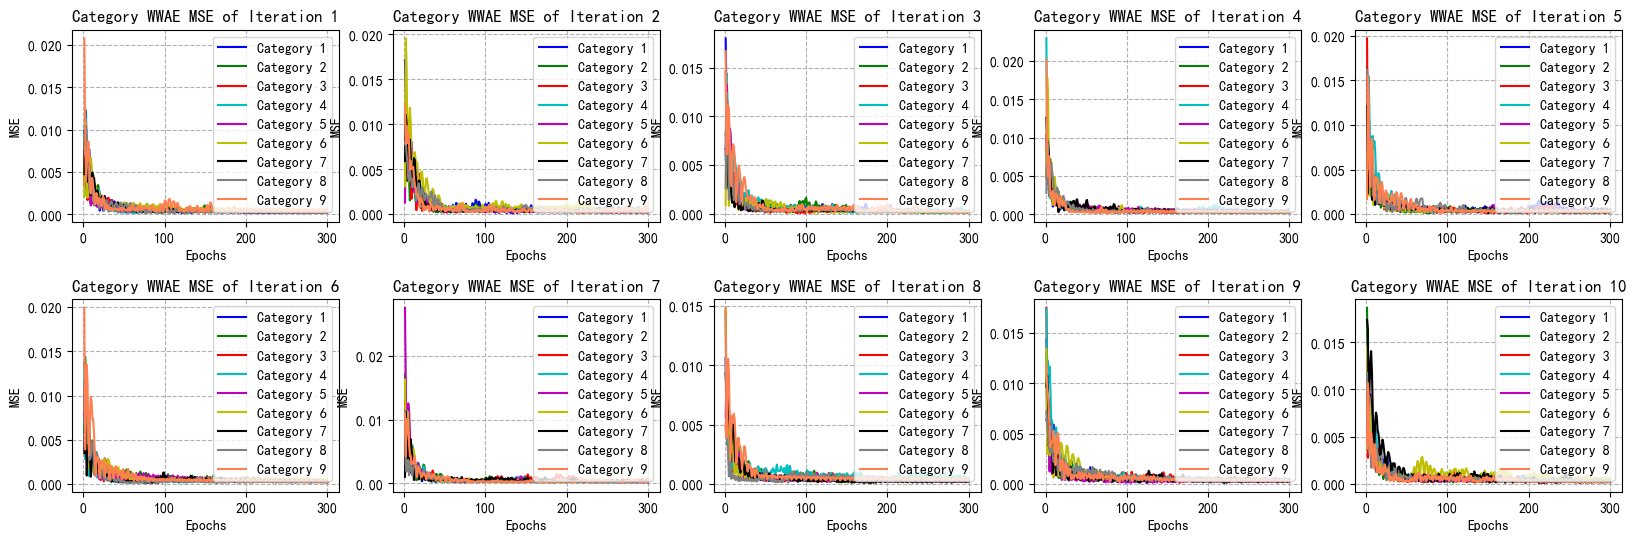

In [76]:
from tqdm import tqdm
from torch.cuda.amp import autocast

eopchs=300
iteration=10
x1 = torch.tensor(np.array(data_trans_train)).to(device='cuda').float()
tqdm_bar=tqdm(range(eopchs))
col=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'gray', 'coral', 'sienna','deeppink', 'deepskyblue', 'chartreuse']

plt.figure(figsize=(20,6))
for ite in range(1,iteration+1):
    plt.subplot(2,5,ite)
    for gro in range(1,len(encoding_inds.unique())+1):
        exec('dt%s=x1[list(encoding_inds==encoding_inds.unique()[gro-1])]'%gro)
        if len(x1[list(encoding_inds==encoding_inds.unique()[gro-1])])==1:
            exec('dt%s=pd.DataFrame(dt%s.cpu().detach().numpy())'%(gro,gro))
            continue
        exec('dt_adddim%s=tf.expand_dims(dt%s.cpu(),1)'%(gro,gro))
        exec('dt_adddim%s=torch.tensor(np.array(dt_adddim%s))'%(gro,gro))
        exec('dt_adddim%s = dt_adddim%s.to(device="cuda").float()'%(gro,gro))
        iwae=IWAE(1,100).to('cuda')
        optimizer = torch.optim.AdamW(iwae.parameters(), lr=1e-3)
        exec('loss_list%s_%s=[]'%(ite,gro))
        for i in tqdm_bar:
            optimizer.zero_grad()
            with autocast():
                exec('recon, input, mu, log_var, z, eps=iwae.forward(dt_adddim%s)'%gro)
                loss=iwae.loss_function(recon, input, mu, log_var)
                exec('loss_list%s_%s.append(loss["loss"].cpu().detach().numpy())'%(ite,gro))
            loss['loss'].backward()
            optimizer.step()
            tqdm_bar.set_description('loss: {}'.format(loss['loss']))
        
        # plot MSE figure
        exec('plt.plot(range(1,eopchs+1),loss_list%s_%s,"%s",label="Category %s")'%(ite,gro,col[gro-1],gro))

        exec('dt_generate%s=iwae.sample(round(0.1*len(dt_adddim%s)))'%(gro,gro)) # generate new data
        exec('dt%s=pd.DataFrame(dt%s.cpu().detach().numpy())'%(gro,gro))
        exec('dt_generate%s=pd.DataFrame(dt_generate%s.cpu().detach().numpy())'%(gro,gro))
        exec('dt%s=pd.concat([dt%s,dt_generate%s],axis=0)'%(gro,gro,gro))
    plt.title('Category WWAE MSE of Iteration %s'%ite)
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.grid(linestyle='--')
    plt.legend()

    for j in range(2,len(encoding_inds.unique())+1):
        exec('dt1=pd.concat([dt1,dt%s],axis=0)'%j)
    exec('dt1_%s=dt1'%ite)
    
plt.subplots_adjust(hspace=0.4)
plt.show()

### Save the data

In [ ]:
for i in range(1,iteration+1):
    exec('dt1_%s.to_csv("vqwwvae_other_data/dt1_%s.csv",index=0,header=0)'%(i,i))

### Load the data

In [ ]:
for i in range(1,iteration+1):
    exec('dt1_%s=pd.read_csv("vqwwvae_other_data/dt1_%s.csv",header=None)'%(i,i))

### Use the NN to evaluate the generating data

In [87]:
class BP_net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden1, n_output, GA_parameter):
        super(BP_net, self).__init__()
        # latent layers and output layer
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)
        self.bn1=torch.nn.BatchNorm1d(n_hidden1)
        self.output = torch.nn.Linear(n_hidden1, n_output)
        # initialize the parameters
        self.hidden1.weight = torch.nn.Parameter(GA_parameter[0])
        self.hidden1.bias = torch.nn.Parameter(GA_parameter[1])
        self.output.weight = torch.nn.Parameter(GA_parameter[2])
        self.output.bias = torch.nn.Parameter(GA_parameter[3])
 
    def forward(self, x):
        hid1 = torch.relu(self.hidden1(x))
        hid1 = self.bn1(hid1)
        out = self.output(hid1)
        return out

def ttrain(model, epochs, learning_rate, x_train, y_train):
    loss_fc = torch.nn.MSELoss(reduction="mean")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_list = []
    for _ in range(epochs):
        model.train()
        # forward
        data = model(x_train)
        # loss
        loss = loss_fc(data, y_train)
        loss_list.append(loss)
        # update the gradient
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
    loss_ls = [loss_list[i].cpu().detach().numpy() for i in range(len(loss_list))]
    return loss_ls

In [78]:
for i in range(1,iteration+1):
    torch.manual_seed(13)
    GA_para=[torch.randn(15,13).cuda(),torch.randn(1,15).cuda(),torch.randn(1,15).cuda(),torch.randn(1,1).cuda()]
    exec('model1_%s=BP_net(13, 15, 1, GA_para)'%i)
    exec('model1_%s.to("cuda")'%i)
    exec('dt1_%s_tr=torch.tensor(np.array(dt1_%s)).to("cuda").float()'%(i,i))
    exec('loss_new_%s = ttrain(model1_%s, 2000, 0.001, dt1_%s_tr[:,:13], dt1_%s_tr[:,13:].reshape(-1,1))'%(i,i,i,i))

In [ ]:
test_use[:,13:]

In [89]:
# testing loss
# pre=model(x1_test[:,:60])
# loss_test=mean_squared_error(pre.cpu().detach().numpy(), x1_test[:,60:].cpu().detach().numpy())
# print('NN testing MSE:',loss_test)
test_use=torch.tensor(np.array(data_trans_test)).to('cuda').float()
mean_loss_test=[]
mean_mae_test=[]
mean_mape_test=[]
mean_r2_test=[]
for i in range(1,iteration+1):
    exec('pre1_%s=model1_%s(test_use[:,:13])'%(i,i))
    exec('mean_loss_test.append(mean_squared_error(pre1_%s.cpu().detach().numpy(), test_use[:,13:].cpu().detach().numpy()))'%i)
    exec('mean_mae_test.append(mean_absolute_error(pre1_%s.cpu().detach().numpy(), test_use[:,13:].cpu().detach().numpy()))'%i)
    exec('mean_mape_test.append(mean_absolute_percentage_error(test_use[:,13:].cpu().detach().numpy(), pre1_%s.cpu().detach().numpy()))'%i)
    exec('mean_r2_test.append(r2_score(test_use[:,13:].cpu().detach().numpy(), pre1_%s.cpu().detach().numpy()))'%i)
loss_test=np.mean(mean_loss_test)
mae_test=np.mean(mean_mae_test)
mape_test=np.mean(mean_mape_test)
r2_test=np.mean(mean_r2_test)
print("VQWWAE's mean testing MSE:",loss_test)
print("VQWWAE's mean testing MAE:",mae_test)
print("VQWWAE's mean testing MAPE:",mape_test)
print("VQWWAE's mean testing R2:",r2_test)

VQWWAE's mean testing MSE: 0.1341609
VQWWAE's mean testing MAE: 0.2889483
VQWWAE's mean testing MAPE: 0.54902476
VQWWAE's mean testing R2: -21.049735662031956


In [93]:
kkt = []
kkt.append(r2_score(sc.inverse_transform(test_use[:,13:].cpu().detach().numpy()), sc.inverse_transform(pre1_1.cpu().detach().numpy())))

ValueError: non-broadcastable output operand with shape (1000,1) doesn't match the broadcast shape (1000,14)

In [ ]:
test_use[:,13:]

In [ ]:
print(np.std(mean_loss_test))
print(np.std(mean_mae_test))
print(np.std(mean_mape_test))

0.034403265
0.0138050625
0.28270972


### Save the model

In [ ]:
for i in range(1,iteration+1):
    exec('joblib.dump(model1_%s,"save/model1_%s.dat")'%(i,i))

### Load the model

In [ ]:
for i in range(1,iteration+1):
    exec('model1_%s = joblib.load("save/model1_%s.dat")'%(i,i))
    exec('pre1_%s=model1_%s(x1_test[:,:60])'%(i,i))

## 0.0

In [96]:
# instantiation
torch.manual_seed(13)
GA_para=[torch.randn(15,13).cuda(),torch.randn(1,15).cuda(),torch.randn(1,15).cuda(),torch.randn(1,1).cuda()]
p0model=BP_net(13, 15, 1, GA_para)
p0model.to('cuda')

BP_net(
  (hidden1): Linear(in_features=13, out_features=15, bias=True)
  (bn1): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=15, out_features=1, bias=True)
)

In [98]:
# training loss
# dt_tr=torch.tensor(np.array(dt)).to('cuda')
loss_or = ttrain(p0model, 900, 0.001, torch.tensor(np.array(data_trans_train.iloc[:,:13])).to('cuda').float(), torch.tensor(np.array(data_trans_train.iloc[:,13:])).to('cuda').float())

In [102]:
# testing loss
pre0=p0model(torch.tensor(np.array(data_trans_test.iloc[:,:13])).to('cuda').float())
loss_test0=mean_squared_error(pre0.cpu().detach().numpy(), data_trans_test.iloc[:,13:])
mae_test0=mean_absolute_error(pre0.cpu().detach().numpy(), data_trans_test.iloc[:,13:])
mape_test0=mean_absolute_percentage_error(data_trans_test.iloc[:,13:], pre0.cpu().detach().numpy())
r2_test0=r2_score(data_trans_test.iloc[:,13:], pre0.cpu().detach().numpy())
print('original data testing MSE:',loss_test0)
print('original data testing MAE:',mae_test0)
print('original data testing MAPE:',mape_test0)
print('original data testing R2:',r2_test0)

original data testing MSE: 0.15678720653348502
original data testing MAE: 0.32059967806196127
original data testing MAPE: 0.6028980996197411
original data testing R2: -24.768433211720698
